In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, LSTM, Input, BatchNormalization
import sklearn
from sklearn import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

tf.config.optimizer.set_jit(True)

2024-03-09 21:27:13.926906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 21:27:13.927038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 21:27:14.084249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!echo "{\"username\":\"alirezakamyab\",\"key\":\"770da05fdb5e552d94f2286462314b29\"}" > kaggle.json
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c g-research-crypto-forecasting

 99%|██████████████████████████████████████▋| 1.12G/1.13G [00:12<00:00, 151MB/s]
100%|██████████████████████████████████████| 1.13G/1.13G [00:12<00:00, 96.9MB/s]


In [4]:
!unzip -q g-research-crypto-forecasting.zip

In [5]:
df = pd.read_csv("train.csv")
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
CURRENCIES = {0:'BinanceCoin', 1:'BitCoin', 9:'Litecoin', 6:'Ethereum'}

total_df = None
for k, v in CURRENCIES.items():
    df_k = df[df['Asset_ID'] == k].copy()
    df_k = df_k.set_index('timestamp')
    df_k = df_k[['Close', 'Volume']]
    df_k = df_k.rename(columns={'Close':f'{v}_Close', 'Volume':f'{v}_Volume'})
    if total_df is None:
        total_df = df_k
    else:
        total_df = total_df.join(df_k)

total_df = total_df.dropna()
total_df.head()

,BinanceCoin_Close,BinanceCoin_Volume,BitCoin_Close,BitCoin_Volume,Litecoin_Close,Litecoin_Volume,Ethereum_Close,Ethereum_Volume
timestamp,,,,,,,,
1514764860,8.5300,78.38,13850.176,31.550062,225.206667,411.896642,738.5075,335.987856
1514764920,8.5145,71.39,13828.102,31.046432,224.856667,3640.502706,738.2600,232.793141
1514764980,8.4848,1546.82,13801.314,55.061820,226.000000,328.350286,737.5025,174.138031
1514765040,8.5009,125.80,13768.040,38.780529,224.275000,507.405579,737.1025,165.383926
1514765100,8.4560,125.01,13724.914,108.501637,223.820000,1035.671830,735.7050,193.078039


In [7]:
SEQ_LEN = 60 # minutes
FUTURE_PERIOD_PREDICT = 3 # minutes
CRYPTO_KEY = 1
USE_ONLY_UPTO = 100_000 # How much data should we use

In [8]:
def preprocess_df(total_df):
    df = total_df.copy()
    df['Future'] = df[f'{CURRENCIES[CRYPTO_KEY]}_Close'].shift(-FUTURE_PERIOD_PREDICT)
    df = df.dropna()

    df['Target'] = df.apply(lambda x: int(x['Future'] > x[f'{CURRENCIES[CRYPTO_KEY]}_Close']), axis=1)
    df = df.drop(labels=['Future'], axis=1)

    for col in df.columns:
        if col != 'Target':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    df.dropna(inplace=True)
    return df.iloc[:USE_ONLY_UPTO]

main_df = preprocess_df(total_df)

# Train/test split
VALIDATION_SPLIT = 0.4
timestamps = sorted(main_df.index.values)
total = len(timestamps)
training_timestamps = timestamps[:int((1 - VALIDATION_SPLIT) * total)]
validation_timestamps = timestamps[int((1 - VALIDATION_SPLIT) * total):]

training_df = main_df.loc[training_timestamps]
validation_df = main_df.loc[validation_timestamps]

training_df.head(50)

,BinanceCoin_Close,BinanceCoin_Volume,BitCoin_Close,BitCoin_Volume,Litecoin_Close,Litecoin_Volume,Ethereum_Close,Ethereum_Volume,Target
timestamp,,,,,,,,,
1514765340,-0.028291,-0.011816,-0.065964,-0.348222,0.497094,-0.000134,0.214765,-0.005157,0
1514765400,0.866625,-0.014414,-0.022437,-0.232311,2.517736,-0.009489,-0.790286,-0.018892,0
1514765460,-0.008541,-0.001528,-0.794583,-0.196953,-2.235060,-0.007287,0.244075,0.009117,0
1514765520,-1.348821,-0.014082,-0.932527,-0.514751,1.726050,-0.003526,-0.049056,-0.010016,0
1514765580,3.119835,-0.010869,0.336318,-0.361293,-0.512401,-0.008126,0.287642,0.010487,0
1514765640,-0.565186,-0.012717,0.059842,0.220213,-2.502252,-0.005186,0.210641,-0.027042,0
1514765700,-0.729655,-0.013787,-1.146255,0.069272,-1.553931,-0.003242,-0.094708,0.011492,0
1514765760,-0.021664,-0.013916,-4.454968,-0.113559,3.107208,-0.008232,-0.271269,-0.021594,1
1514765820,-0.533704,-0.013354,1.297324,-0.060500,-3.064143,-0.000983,-0.078140,-0.007192,0


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
SHUFFLE_BUFFER = 512

def split_data_label(data):
    target = data[-1, -1]
    data = data[:, :-1]
    return data, target

train_data = tf.data.Dataset.from_tensor_slices(training_df.values)
train_data = train_data.window(size=SEQ_LEN, shift=1, drop_remainder=True)
train_data = train_data.flat_map(lambda window: window.batch(SEQ_LEN))
train_data = train_data.map(split_data_label, num_parallel_calls=AUTOTUNE)
train_data = train_data.cache()
train_data = train_data.shuffle(SHUFFLE_BUFFER)
train_data = train_data.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)


test_data = tf.data.Dataset.from_tensor_slices(validation_df.values)
test_data = test_data.window(size=SEQ_LEN, shift=1, drop_remainder=True)
test_data = test_data.flat_map(lambda window: window.batch(SEQ_LEN))
test_data = test_data.map(split_data_label, num_parallel_calls=AUTOTUNE)
test_data = test_data.cache()
test_data = test_data.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)

In [10]:
model = keras.Sequential([
    Input(shape=(SEQ_LEN, 8)),
    LSTM(units=128, return_sequences=True),
    Dropout(0.4),

    LSTM(units=128, return_sequences=True),
    Dropout(0.4),

    LSTM(units=256),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,258 (2.31 MB)

 Trainable params: 604,258 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
initial_lr = 0.001
def scheduler(epoch):
    return initial_lr * 0.8 ** epoch

learningRateScheduler = LearningRateScheduler(scheduler)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=initial_lr),
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=test_data,
    callbacks=[learningRateScheduler]
)

Epoch 1/20


I0000 00:00:1710019783.403659     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    937/Unknown 26s 16ms/step - accuracy: 0.5069 - loss: 0.6937

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


937/937 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5069 - loss: 0.6937 - val_accuracy: 0.4843 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5007 - loss: 0.6934 - val_accuracy: 0.4840 - val_loss: 0.6929 - learning_rate: 8.0000e-04
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.5008 - loss: 0.6934 - val_accuracy: 0.4843 - val_loss: 0.6926 - learning_rate: 6.4000e-04
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.5331 - val_loss: 0.6906 - learning_rate: 5.1200e-04
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5144 - loss: 0.6929 - val_accuracy: 0.5161 - val_loss: 0.6917 - learning_rate: 4.0960e-04
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5279 - loss: 0.6915 - val_accuracy: 0.5286 - val_loss: 0.6901 - learning_rate: 3.2768e-04
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0

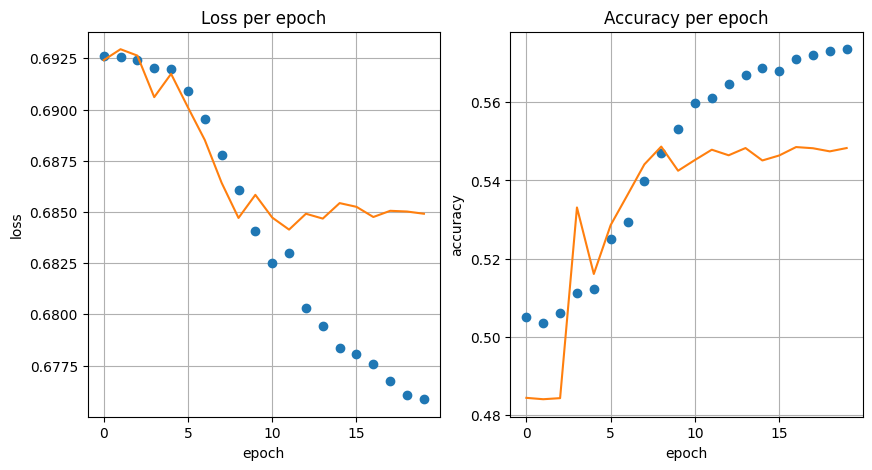

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.plot(history.epoch, history.history['loss'], 'o', label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.grid(True)

ax = plt.subplot(122)
ax.plot(history.epoch, history.history['accuracy'], 'o', label='training')
ax.plot(history.epoch, history.history['val_accuracy'], label='validation')
ax.set_title('Accuracy per epoch')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.grid(True)

In [ ]:
# END